# Assignment 2

**Deadline**:  Sunday 12 December, 23.59.

Your notebook should not give errors when executed with `Run All`. Please submit your answers via [Canvas](https://canvas.uva.nl/courses/25150/assignments/248823).

|**Name**|**Student ID**|**Email**|
|:Jinhyun Kim|:11968850|:kjin5065@gmail.com|


#### Hand in the following:
* Your notebook. **click on `Kernel`, then `Restart & Run All`** before submitting.
* A (printed) pdf version of your notebook.

#### NOTES:
* This is an individual assignment. Teamwork is **not** permitted, including during lectures.
* The assignment is a partial stand-in for a final examination, so the usual rules regarding plagiarism and fraud apply, with all attendant consequences. Code found on the internet or elsewhere is not acceptable as a solution.
* Efficient code is required for full marks.
* Make sure that any function you write has a docstring, and comments where appropriate.
* Before submitting your work, **click on `Kernel`, then `Restart & Run All`** and verify that your notebook produces the desired results and does not error.
* Some questions require you to write code to obtain a numerical result (e.g., an option price). In that case, don't just give the function, but also the result of calling it with the given parameter values (i.e., the numerial value that it returns). If your function uses random numbers, then set the seed to 0 before calling it. This makes it much easier to grade the assignments (at least as long as the answer is correct).
* How to convert your notebook to pdf: The easiest way is probably to use your browser's print functionality: e.g. in Chrome, press the three dots to go to Options, select 'Print...', and then select 'save as pdf' as Destination. I usually set it to 70% zoom such that the output fits the printed pdf pages.


#### Declaration of Originality:
By submitting these answers, I declare that
1. I have read and understood the notes above.
2. These solutions are solely my own work.
3. I have not made these solutions available to any other student.

**Question A**:
Consider an $N$-period model with two assets: a riskless bond with value $B_t=e^{rt}$, and a stock that evolves according to a binomial tree, such that $S_t=S_{t-\Delta t}u$ or $S_t=S_{t-\Delta t}d$ in the good and bad states of the world, respectively. Here $u=1/d=\exp(\sigma\sqrt{\Delta t})$ and $\Delta t= T/N$ as usual. We would like to price a *chooser* option, which has the property that, after $M<N$ periods, the holder can choose whether the option is a European call or put option, both maturing after $N$ periods, and with the same strike price $K$ (See Hull, section 25.7 (ed. 8) or 26.8 (ed. 9, 10, or 11)). Denoting their prices after $i$ periods as $C_{i}$ and $P_{i}$, respectively, the value of the chooser option after $M$ periods is $V_{M}=\max \{C_{M},P_{M}\}\,$. Our starting point is the function `calltree` (or `calltree_numpy`) from Week 5. 

**For each of the following subquestions, your answer should include the function itself, as well as the result of calling it with the following parameter values**: $S_0 = 12$, $K = 15$, $T = 3/12$, $r = 0.02$, $\sigma = 0.25$, $q = 0.01$, $N = 500$, $M=200$.

   1. We want to allow for a dividend yield, $q$. Modify `calltree_numpy` to accept an additional input argument `q`. That is, the function becomes `calltree_numpy(S0, K, T, r, sigma, q, N)`. In the function change the risk-neutral probability to $(e^{(r-q)\Delta t}-d)/(u-d)$.
   2. Building on your function from the previous question write a function `chooser(S0, K, T, r, sigma, q, N, M)` that prices a European chooser option. Along with the call price tree, this function should also compute a put price tree stored in a matrix `P` (of the same size as the call price matrix). Following computation of `C` and `P`, create a $(M+1) \times (M+1)$ matrix `CH`, which stores the tree for the chooser option. At point in time `M`, the last column of this tree will be populated with $V_M=\max \{C_{M},P_{M}\}\,$. Based on the `CH` tree perform the backwards induction to determine the price of the chooser.
   3. Now consider a chooser option for which after $M$ periods, the holder will choose between an *American* call or an *American* put (above we were choosing between a *European* call and a *European* put). Modify the function from above so that before populating the chooser tree `CH` the first loop also determines whether to exercise or keep the respective *American* put and *American* call. Call the function that evaluates the price of this particular derivative `chooser_american(S0, K, T, r, sigma, q, N, M)`.
   4. For the given parameters values ($S_0$, $K$, $T$, $r$, $\sigma$, $q$, $N$) plot the prices of `chooser` and `chooser_american` as a function of $M$. That is, produce a graph that has the prices of the two options on the y-axis and $M$ on the x-axis. Describe and explain (in words) the price convergence.

In [3]:
# importing package
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


## QA- 1

In [4]:
def calltree_numpy(S0, K, T, r, sigma, q, N):
    """
    European call price based on an N-step binomial tree 
    with a consideration for a dividend yield, q
    """
    deltaT = T / float(N)
    u = np.exp(sigma*np.sqrt(deltaT))
    d = 1.0 / u
    p = (np.exp((r-q)*deltaT)-d) / (u-d)
    piu = np.exp(-r*deltaT) * p #The probabilty of price goes up.
    pid = np.exp(-r*deltaT) * (1-p) #The probabiltu of price goes down. 
    C = np.zeros((N+1, N+1))
    
    # Stock price
    S = S0 * u**np.arange(N+1) * d**(2*np.arange(N+1)[:, np.newaxis])
    S = np.triu(S)  #keep only the upper triangular part

    # Final payoffs
    C[:, N] = np.maximum(0, S[:, N]-K)  #note: np.maximum in place of max
    
    # Work backwards through the tree
    for j in range(N-1, -1, -1):
        C[:j+1, j] = piu * C[:j+1, j+1] + pid * C[1:j+2, j+1]

    return  C[0, 0]

print(calltree_numpy(12, 15, 3/12, 0.02, 0.25, 0.01, 500))

0.025863747363824963


## QA-2

In [5]:
def chooser(S0, K, T, r, sigma, q, N, M):
    """
    European call price based on an N-step binomial tree 
    with a consideration for a dividend yield, q. 
    At M step, people can choose between put and call option(European option).
    """
    deltaT = T / float(N)
    u = np.exp(sigma*np.sqrt(deltaT))
    d = 1.0 / u
    p = (np.exp((r-q)*deltaT)-d) / (u-d)
    piu = np.exp(-r*deltaT) * p
    pid = np.exp(-r*deltaT) * (1-p)
    C = np.zeros((N+1, N+1)) # Create an empty matrics for the put option
    P = np.zeros((N+1, N+1)) # Create an empty matrics for the put option

    # Stock price
    S = S0 * u**np.arange(N+1) * d**(2*np.arange(N+1)[:, np.newaxis])
    S = np.triu(S)  #keep only the upper triangular part

    # Final call option payoffs 
    C[:, N] = np.maximum(0, S[:, N]-K)  #note: np.maximum in place of max
    
    # Final put option payoffs 
    P[:, N] = np.maximum(0, K- S[:, N])  #note: np.maximum in place of max   
    
    # Work backwards through the tree. Store the value of options at every step.
    for j in range(N-1, -1, -1):
        C[:j+1, j] = piu * C[:j+1, j+1] + pid * C[1:j+2, j+1]
        P[:j+1, j] = piu * P[:j+1, j+1] + pid * P[1:j+2, j+1]
    
    # To store the tree for the chooser option.
    CH = np.zeros((M+1, M+1)) 

    # Store higher option prices between call option and put option at M step.
    CH[:, M] = np.maximum(C[:M+1, M], P[:M+1, M])

    # Work backwards through the tree
    for j in range(M-1, -1, -1):
        CH[:j+1, j] = piu * CH[:j+1, j+1] + pid * CH[1:j+2, j+1]
    
    return  CH[0,0]

print(chooser(12, 15, 3/12, 0.02, 0.25, 0.01, 500, 200))

2.981816416843708


## QA-3

In [6]:
def chooser_american(S0, K, T, r, sigma, q, N, M):
    """
    American option price based on an N-step binomial tree 
    with a consideration for a dividend yield, q. 
    At M step, people can choose between put and call option(American option).
    """
    deltaT = T / float(N)
    u = np.exp(sigma*np.sqrt(deltaT))
    d = 1.0 / u
    p = (np.exp((r-q)*deltaT)-d) / (u-d)
    piu = np.exp(-r*deltaT) * p
    pid = np.exp(-r*deltaT) * (1-p)
    C = np.zeros((N+1, N+1)) # Create an empty matrics for the put option
    P = np.zeros((N+1, N+1)) # Create an empty matrics for the put option

    # Stock price
    S = S0 * u**np.arange(N+1) * d**(2*np.arange(N+1)[:, np.newaxis])
    S = np.triu(S)  #keep only the upper triangular part
    
    # Final call option payoffs (N step).
    C[:, N] = np.maximum(0, S[:, N]-K)  #note: np.maximum in place of max
    
    # Final put option payoffs (N step).
    P[:, N] = np.maximum(0, K- S[:, N])  #note: np.maximum in place of max   
    
    # Work backwards through the tree
    for j in range(N-1, -1, -1):
        C[:j+1, j] = piu * C[:j+1, j+1] + pid * C[1:j+2, j+1]
        C[:j+1, j] = np.maximum(C[:j+1, j], S[:j+1, j]- K )
        P[:j+1, j] = piu * P[:j+1, j+1] + pid * P[1:j+2, j+1]
        P[:j+1, j] = np.maximum(P[:j+1, j], K-S[:j+1, j]  )
     
    # To store the tree for the chooser option.
    CH = np.zeros((M+1, M+1)) 

    # Final higher option prices between call option and put option at M time.
    CH[:, M] = np.maximum(C[:M+1, M], P[:M+1, M])

    # Work backwards through the tree
    for j in range(M-1, -1, -1):
        CH[:j+1, j] = piu * CH[:j+1, j+1] + pid * CH[1:j+2, j+1]

    return  CH[0,0]

print(chooser_american(12, 15, 3/12, 0.02, 0.25, 0.01, 500, 200))

3.0019380410392396


## QA-4

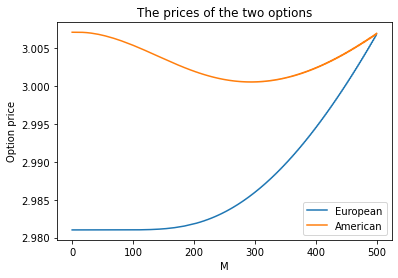

In [7]:
def plotting (S0, K, T, r, sigma, q, N ):
    M = np.arange(0, N)
    y1 = [chooser(S0, K, T, r, sigma, q, N, i) for i in M ]
    y2 = [chooser_american(S0, K, T, r, sigma, q, N, j) for j in M ]
    
    # depicting the visualization
    plt.plot(M, y1, label='European')
    plt.plot(M, y2, label='American')
    plt.ylabel('Option price')
    plt.xlabel('M')
    plt.legend()

    # displaying the title
    plt.title("The prices of the two options")
    
    plt.show()


plotting (12, 15, 3/12, 0.02, 0.25, 0.01, 500)

## QA-4 Interpretation

When the decision point time M get larger, we can see the two option prices converge to the same. When M is small, the price of the American option is higher than that of the european otpion. However the difference get smaller with an increase of M. The intuition behind this movement is that option price worth more when people have a choice to exercie earlier or not.

 **Question B**:

 We wish to obtain the no-arbitrage price $X_{0}$ of an index-linked certificate. The derivative has payoff $X_{T}$, defined from the path of an equity index $\{S_{t}\}_{0\leq t\leq T}$ as follows:
 $$
 X_{T}=S_{0}\prod\nolimits_{t=1}^{T}(1+\max (R_{t},R)),\qquad R_{t}=\frac{S_{t}-S_{t-1}}{S_{t-1}},\qquad R=e^{r}-1,
 $$
 where $r\equiv \log (1+R)$ is the continuously compounded interest rate, so that $R$ is the corresponding annually compounded interest rate. Time is measured in years, and $T$ is a positive integer, representing the number of years after which the payoff is received. The idea behind this derivative is that the investor participates in the upside potential of the stock market, but receives a guaranteed minimum return. The value $X_{0}$ of this product cannot be evaluated analytically. 

 We assume a Black-Scholes economy and use the following parameter values: $S_0=9$, $T=10$, $R=0.02$, $\sigma =0.25$, and $q =0.01$. 
     
   1. Using `asianmc_vec` (and `bmsim_vec`) as a starting point, modify the `payoff` of the derivative accordingly. Call the function `certificatemc(S0, R, T, sigma, q, numsim=10000)`, which will return the Monte Carlo estimate of $X_{0}$, along with a 95% confidence interval. **Notice that both the price (at origination) and the CI should be stated explicitly in your answers, based on a random seed of 0**.
   
   2. Test if the confidence interval returned by `certificatemc` has correct coverage, by simulating 1000 independent ones (with `numsim=1000`), and recording in a hit series $I_j$, $j\in\{1, \ldots, 1000\}$, whether an interval contains the true price ($I_j=1$) or not ($I_j=0$). The test can be conducted by regressing $\{I_j-0.95\}_{j=1}^{1000}$ on an intercept and testing whether that is zero. The 'true' price should be obtained from `certificatemc` with `numsim=100000`.

## Q2-1

In [10]:
np.random.seed(0)

def bmsim_vec(T, numsim, X0=0, mu=0, sigma=0.25):  #input: numsim, the number of paths.
    """Simulate `numsim` Brownian motion paths."""
    deltaT = float(T)/T #Set delta T as total period(T) divided by T.
    tvec = np.linspace(0, T, T+1) #Make an array that has distance of (0+T)/(T+1) from 0 to T.
    z = np.random.randn(numsim, T+1) #Create an random array with 'numsim' rows and 'N+1' columns.
    dX = mu*deltaT + sigma*np.sqrt(deltaT)*z
    dX[:, 0] = 0. #Set all the values of the first columns as 0.
    X = np.cumsum(dX, axis=1) #Make an array that contain the cummulative sum at each row.
    X += X0 #Add the initial stock value to the array 'X'.
    return tvec, X

def certificatemc(S0, T, R, sigma, q, numsim=10000):
    """Monte Carlo price of option with 95% confidence interval."""
    X0 = np.log(S0)
    r = np.log(1+R)
    nu = R-q-.5*sigma**2    
    #Simulate all paths at once:
    _, X = bmsim_vec(T, numsim, X0=0, mu=0, sigma=0.25)
    S = np.exp(X) #Since X is ln(S), we use the exp function to derive the original Stock value. 
    Rt = np.diff(S)/S[:,:-1] #Get the return rate of stock. (R_i1 -Ri)/Ri
    payoffs = S0*(np.cumprod((1+ np.maximum(R, Rt)), axis =1))[:,-1] #Multiply S0 with the product of final maximum rate of returns.
    g = np.exp(-r*T)*payoffs #Calculate the present value of all the payoffs. 
    C = g.mean(); s = g.std() #Get the mean and std of all the pv(payoffs).
    zq = norm.ppf(0.975)
    Cl = C - zq/np.sqrt(numsim)*s
    Cu = C + zq/np.sqrt(numsim)*s
    return C, Cl, Cu
certificatemc(9, 10, 0.02, 0.25, 0.01, numsim=10000)

(24.641632874056782, 24.38771983100421, 24.895545917109356)

In [24]:
len(np.zeros(30).reshape(5,6)[0,:])

6

In [19]:
len(np.zeros(30).reshape(1,30))

1

In [10]:
certificatemc(9, 10, 0.02, 0.25, 0.01, numsim=10)

Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1078, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 297, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "C:\ProgramData\Anaconda3\lib\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 1976, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "C:\ProgramData\Anaconda3\lib\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 2011, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


KeyboardInterrupt: 

Price at origination is 285437.60050258297, and the confidence interval is [271510.13041849, 299365.07058667595]


## Q2-2

In [ ]:
def simulator(S0, T, r, sigma, q, numsim):
    """
    Simulate independent price 'numsim' times.
    In addition, return an array filled with simulated prices.
    """
    arr = np.zeros(numsim) #Create numpy array filled with zero
    return np.array(list(map(lambda x: +certificatemc(S0, T, r, sigma, q, numsim)[0], arr))) #Add simulated indepedent prices to the created array.

def hit_series(S0, T, r, sigma, q, numsim):
    """Return hit series."""
    cf_intv = certificatemc(S0, T, r, sigma, q, numsim = 100000)[1:3] #Extract 95% confidence interval.
    simul_p = simulator(S0, T, r, sigma, q, numsim) #Create array that contain 1000 indenpednet simulated prices.
    return np.array([1 if cf_intv[0] <= price <= cf_intv[1] else 0 for price in simul_p]) #Create hit series.

def tester(S0, T, r, sigma, q, numsim=1000):
    """
    Test if the confidence interval returned by `certificatemc` 
    has correct coverage, by simulating 1000 independent ones.
    """
    Y = hit_series(S0, T, r, sigma, q, numsim) - 0.95
    X = sm.add_constant(np.zeros(numsim))
    model = sm.OLS(Y, X)
    results = model.fit()
    print(results.t_test([1, 0]))
    print(results.t_test)
    print(results.summary())


In [ ]:
tester(9, 10, 0.02, 0.25, 0.01, N=500, numsim=100)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.6000      0.048    -12.516      0.000      -0.695      -0.505
<bound method LikelihoodModelResults.t_test of <statsmodels.regression.linear_model.OLSResults object at 0x000001F7C4C6EE80>>
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 11 Dec 2021   Prob (F-statistic):                nan
Time:                        21:02:32   Log-Likelihood:                -67.864
No. Observations:                 100   AIC:                             137.7
Df Re

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


## Q2-2 Interpretation

From the table above, the t-statistic is -4.058 and the p-value is 0, which reject the null hypotheis of' $\{I_j-0.95\}_{j=1}^{1000}$ = 0. Therefore we can conclude that the simulated price is not equal to the true price. 